# Weed Classification of Soybean images
This machine learning code solves classification problem to identify the weed based on the aerial images that has soybeans. The deep neural network are implemented for this task. The dataset is located in the following location:
https://www.kaggle.com/fpeccia/weed-detection-in-soybean-crops

In [1]:
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import argparse
import time
import os
import copy
import math
import random
import re
import time
from copy import deepcopy

from PIL import Image
import seaborn as sns
import cv2

import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd
from sklearn.utils.multiclass import unique_labels

## Initial parameter setup

In [2]:
train_ratio = 0.6
val_ratio = 0.2
batch_size = 32
num_features = 4

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
data_dir = './dataset/'


cuda:0


## Data preparation

In [3]:
transforms = transforms.Compose([transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()])


# Train and Validation dataset
all_train_dataset = datasets.ImageFolder(root=data_dir, transform=transforms)
num_all_train_data = len(all_train_dataset)
num_train_data = math.floor(num_all_train_data * train_ratio)
num_val_data = math.floor(num_all_train_data * val_ratio)
num_test_data = num_all_train_data - num_train_data - num_val_data
trainset, valset, testset = torch.utils.data.random_split(all_train_dataset, [num_train_data, num_val_data, num_test_data])

dataloaders = {
    'train':
    torch.utils.data.DataLoader(trainset,
                                batch_size=batch_size,
                                shuffle=True,
                                num_workers=0),
    'val':
        torch.utils.data.DataLoader(valset,
                                    batch_size=batch_size,
                                    shuffle=True,
                                    num_workers=0),
    'test':
        torch.utils.data.DataLoader(testset,
                                    batch_size=batch_size,
                                    shuffle=True,
                                    num_workers=0)
}

dataset_sizes = {'train': len(trainset), 'val':len(valset)}
#
# #Test dataset
test_dataloaders = dataloaders['test']

# #Class names
class_names = dataloaders['train'].dataset.dataset.classes

## Data exploration

Number of Class:  4
-------------------------------------------------------Grass-------------------------------------------------------


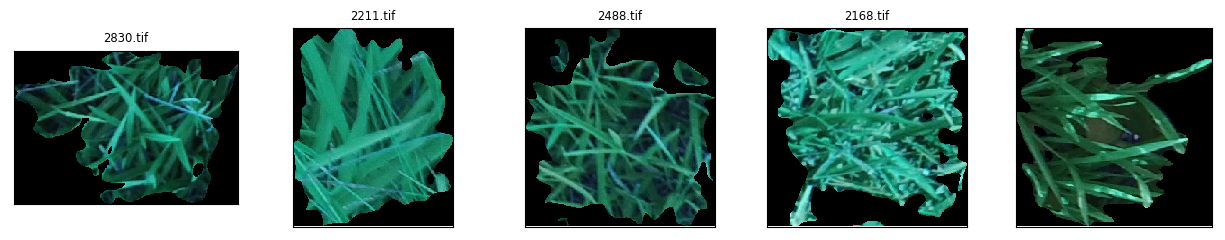


-------------------------------------------------------Soil-------------------------------------------------------


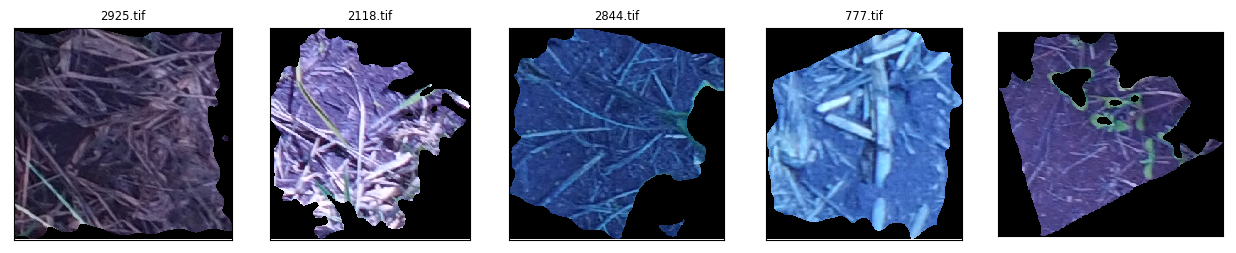


-------------------------------------------------------Broadleaf-------------------------------------------------------


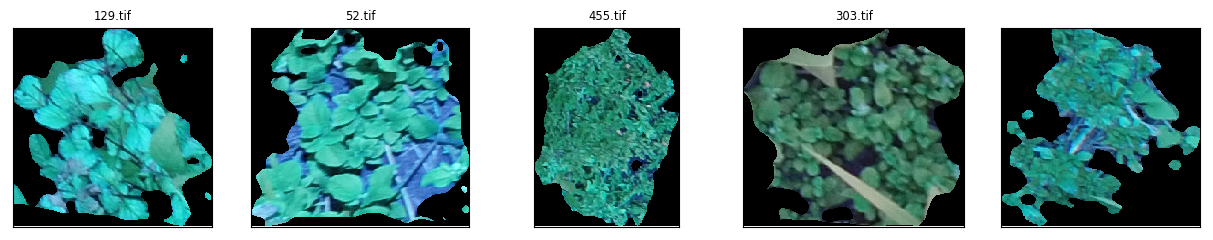


-------------------------------------------------------Soybean-------------------------------------------------------


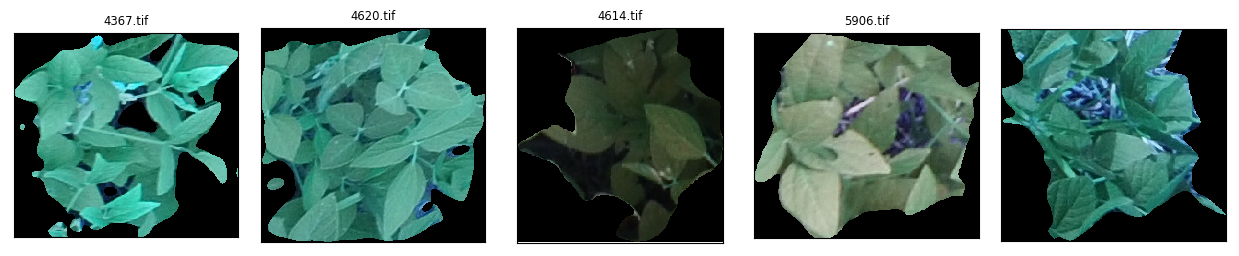


-------------------------------------------------------All Class Printed:4-------------------------------------------------------


In [4]:
def select_image_by_category(image_dir, image_count_per_category):
    classes = os.listdir(image_dir)
    class_count = len(classes)

    image_file_paths = {}

    for i in range(class_count):
        subdir_path = image_dir + classes[i]
        subdir_files = os.listdir(subdir_path)

        subdir_file_count = len(subdir_files)

        subdir_file_mem = {}

        subdir_file_index = -1

        image_file_paths[classes[i]] = []

        for j in range(image_count_per_category):
            while subdir_file_index in subdir_file_mem:
                subdir_file_index = random.randint(0, subdir_file_count - 1)

            subdir_file_mem[subdir_file_index] = 1

            subdir_file_name = subdir_files[subdir_file_index]
            subdir_file_path = subdir_path + "/" + subdir_file_name

            image_file_paths[classes[i]].append(subdir_file_path)

    return image_file_paths


def get_fig_axs(subplot_params):
    fig, axs = plt.subplots(
        nrows=subplot_params["nrows"], ncols=subplot_params["ncols"],
        figsize=(subplot_params["figsize_col"], subplot_params["figsize_row"]),
        dpi=subplot_params["dpi"], facecolor=subplot_params["facecolor"],
        edgecolor=subplot_params["edgecolor"], subplot_kw=subplot_params["subplot_kw"])

    return fig, axs


def plot_sample_image(image_file_paths, plot_params, subplot_params, update_image=True):
    fig, axs = get_fig_axs(subplot_params)

    plt.rcParams.update({'axes.titlesize': plot_params["axes.titlesize"]})
    plt.subplots_adjust(hspace=subplot_params["hspace"], wspace=subplot_params["wspace"])

    i = 0
    for img_filepath in image_file_paths:
        img = cv2.imread(img_filepath, 1)
        plt.title(img_filepath.split("/")[-1])
        plt.subplot(subplot_params["nrows"], subplot_params["ncols"], i + 1)
        plt.imshow(img)

        plt.xticks([])
        plt.yticks([])

        i = i + 1

    if plot_params["update_image"] and os.path.exists(plot_params["image_file_name"]):
        os.remove(plot_params["image_file_name"])
    if plot_params["save"]:
        fig.savefig(plot_params["image_file_name"], dpi=plot_params["dpi"])

    plt.tight_layout()
    plt.show()


def show_class_sample_images(directory, image_count_per_category=5, save=False, dpi=100, update_image=False):
    class_count = len(os.listdir(directory))
    print("Number of Class: ", class_count)
    sample_img_by_class = select_image_by_category(directory, image_count_per_category)
    for class_name in sample_img_by_class:
        plot_params = get_reset_plot_params(image_file_name="img.png", save=save, dpi=dpi, update_image=update_image)
        subplot_params = get_reset_subplot_params(nrows=1, ncols=image_count_per_category, dpi=dpi)
        print("%s%s%s" % ("-" * 55, name_correct(class_name), "-" * 55))
        plot_sample_image(sample_img_by_class[class_name], plot_params, subplot_params)
        print("")
    print("%s%s%d%s" % ("-" * 55, "All Class Printed:", class_count, "-" * 55))


# DATA VISUALIZATION
def get_reset_subplot_params(nrows, ncols, dpi):
    subplot_params = {}
    subplot_params["nrows"] = nrows
    subplot_params["ncols"] = ncols

    subplot_params["figsize_col"] = subplot_params["ncols"] * 2.5
    subplot_params["figsize_row"] = subplot_params["nrows"] * 2.5
    subplot_params["dpi"] = dpi
    subplot_params["facecolor"] = 'w'
    subplot_params["edgecolor"] = 'k'
    subplot_params["subplot_kw"] = {'xticks': [], 'yticks': []}
    subplot_params["axes.titlesize"] = 'small'
    subplot_params["hspace"] = 0.5
    subplot_params["wspace"] = 0.3

    return subplot_params


def get_reset_plot_params(figsize=(15, 5), title="", xlabel="", ylabel="", legends=[], title_fontsize=18,
                          label_fontsize=14, image_file_name="", save=False, dpi=100, update_image=True):
    plot_params = {}

    plot_params["figsize"] = figsize

    plot_params["title"] = title

    plot_params["xlabel"] = xlabel
    plot_params["ylabel"] = ylabel

    plot_params["legends"] = legends

    plot_params["title_fontsize"] = title_fontsize
    plot_params["axes.titlesize"] = "small"
    plot_params["label_fontsize"] = label_fontsize

    plot_params["image_file_name"] = image_file_name
    plot_params["save"] = save
    plot_params["update_image"] = update_image

    plot_params["subplot"] = None
    return plot_params


# Removes everything except alphabetical and selected characters from name string
def name_correct(name):
    return re.sub(r'[^a-zA-Z,:]', ' ', name).title()

show_class_sample_images(data_dir, image_count_per_category=5, save=False, dpi=100, update_image=False)



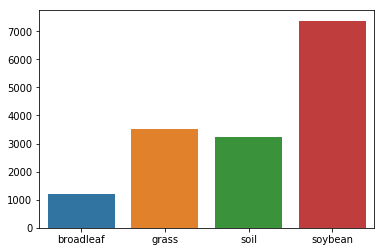

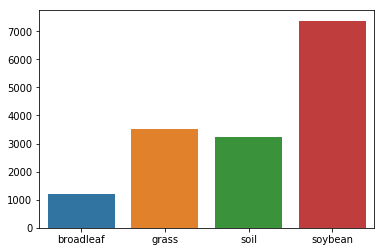

In [5]:


def count_dataset(data):

    '''
    Count the number of dataset in each class
    :param data:
    :return:
    '''

    num_classes = len(data.dataset.dataset.classes)

    count_result = []
    for i in range(num_classes):
        count_result.append(len([j for j in data.dataset.dataset.targets if j==i]))

    return count_result

total_num_class_train = count_dataset(dataloaders['train'])
total_num_class_val = count_dataset(dataloaders['val'])
# total_num_class_test = count_dataset(test_dataset)


fig, ax = plt.subplots(1)
x = trainset.dataset.classes
ax = sns.barplot(x=x, y=total_num_class_train)
# ax[0].title('Train dataset')
fig, ax = plt.subplots(1)
ax = sns.barplot(x=x, y=total_num_class_val)
# ax[1].title('Validation dataset')
plt.show()

## Train/Validate/Test 

In [6]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    unique_lb = unique_labels(y_true, y_pred)
    classes = [classes[unique_i] for unique_i in unique_lb]
    # classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

def train(net, trainloader, optimizer, criterion, args):

    net.train()
    optimizer.zero_grad()

    correct = 0
    total = 0
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = train_loss / len(trainloader)
    train_acc = 100 * correct / total
    return net, train_loss, train_acc


def validate(net, valloader, criterion, args):
    net.eval()

    correct = 0
    total = 0
    val_loss = 0
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            outputs = net(images)

            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(valloader)
        val_acc = 100 * correct / total
    return val_loss, val_acc


def test(net, testloader, args):
    net.eval()

    correct = 0
    total = 0
    true_labels = []
    pred_labels = []
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            true_labels.extend(labels.cpu().numpy().tolist())

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            pred_labels.extend(predicted.cpu().numpy().tolist())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
    return test_acc, true_labels, pred_labels


def experiment(dataloaders, test_dataloaders, args):
    net = models.resnet50(pretrained=True)
    num_ftrs = net.fc.in_features
    net.fc = nn.Linear(num_ftrs, num_features)

    model_ft = net.to(device)
    net.cuda()

    criterion = nn.CrossEntropyLoss()
    if args.optim == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(args.epoch):  # loop over the dataset multiple times
        ts = time.time()
        net, train_loss, train_acc = train(net, dataloaders['train'], optimizer, criterion, args)
        val_loss, val_acc = validate(net, dataloaders['val'], criterion, args)
        te = time.time()

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        
        print(
            'Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.2f}/{:2.2f}. Took {:2.2f} sec'.format(epoch,
                                                                                                                  train_acc,
                                                                                                                  val_acc,
                                                                                                                  train_loss,
                                                                                                                  val_loss,
                                                                                                                  te - ts))

    test_acc, true_labels, pred_labels = test(net, test_dataloaders, args)
    plot_confusion_matrix(true_labels, pred_labels, classes=class_names,
                          title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plot_confusion_matrix(true_labels, pred_labels, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')

    plt.show()
    plt.show()

    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    return vars(args), result



## Manage Experiment Results

In [7]:
def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    del setting['epoch']
    del setting['test_batch_size']

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = './results/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting)
    with open(filename, 'w') as f:
        json.dump(result, f)


def load_exp_result(exp_name):
    dir_path = './results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result)  # .drop(columns=[])
    return df

#####################################################
# Manage Experiment Result
#####################################################
def plot_acc(var1, var2, df):
    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(15, 6)
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})

    sns.barplot(x=var1, y='train_acc', hue=var2, data=df, ax=ax[0])
    sns.barplot(x=var1, y='val_acc', hue=var2, data=df, ax=ax[1])
    sns.barplot(x=var1, y='test_acc', hue=var2, data=df, ax=ax[2])

    ax[0].set_title('Train Accuracy')
    ax[1].set_title('Validation Accuracy')
    ax[2].set_title('Test Accuracy')


def plot_loss_variation(var1, var2, df, **kwargs):
    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1] == value1]
            row = row.loc[df[var2] == value2]

            train_losses = list(row.train_losses)[0]
            val_losses = list(row.val_losses)[0]

            for epoch, train_loss in enumerate(train_losses):
                list_data.append({'type': 'train', 'loss': train_loss, 'epoch': epoch, var1: value1, var2: value2})
            for epoch, val_loss in enumerate(val_losses):
                list_data.append({'type': 'val', 'loss': val_loss, 'epoch': epoch, var1: value1, var2: value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'loss', marker='.')
    g.add_legend()
    g.fig.suptitle('Train loss vs Val loss')
    plt.subplots_adjust(top=0.89)


def plot_acc_variation(var1, var2, df, **kwargs):
    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1] == value1]
            row = row.loc[df[var2] == value2]

            train_accs = list(row.train_accs)[0]
            val_accs = list(row.val_accs)[0]
            test_acc = list(row.test_acc)[0]

            for epoch, train_acc in enumerate(train_accs):
                list_data.append({'type': 'train', 'Acc': train_acc, 'test_acc': test_acc, 'epoch': epoch, var1: value1,
                                  var2: value2})
            for epoch, val_acc in enumerate(val_accs):
                list_data.append(
                    {'type': 'val', 'Acc': val_acc, 'test_acc': test_acc, 'epoch': epoch, var1: value1, var2: value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'Acc', marker='.')

    def show_acc(x, y, metric, **kwargs):
        plt.scatter(x, y, alpha=0.3, s=1)
        metric = "Test Acc: {:1.3f}".format(list(metric.values)[0])
        plt.text(0.05, 0.95, metric, horizontalalignment='left', verticalalignment='center',
                 transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))

    g = g.map(show_acc, 'epoch', 'Acc', 'test_acc')

    g.add_legend()
    g.fig.suptitle('Train Accuracy vs Val Accuracy')
    plt.subplots_adjust(top=0.89)

## Experiment

Namespace(act='relu', epoch=20, exp_name='exp1_lr', l2=1e-05, lr=0.0001, optim='RMSprop', test_batch_size=1024, train_batch_size=512)
Epoch 0, Acc(train/val): 93.24/93.94, Loss(train/val) 0.22/0.18. Took 160.73 sec
Epoch 1, Acc(train/val): 97.13/97.42, Loss(train/val) 0.09/0.08. Took 164.94 sec
Epoch 2, Acc(train/val): 97.38/93.74, Loss(train/val) 0.09/0.19. Took 167.69 sec
Epoch 3, Acc(train/val): 97.20/97.39, Loss(train/val) 0.09/0.10. Took 165.46 sec
Epoch 4, Acc(train/val): 97.86/97.46, Loss(train/val) 0.07/0.06. Took 168.09 sec
Epoch 5, Acc(train/val): 98.35/98.50, Loss(train/val) 0.05/0.04. Took 171.45 sec
Epoch 6, Acc(train/val): 98.48/99.05, Loss(train/val) 0.05/0.04. Took 163.93 sec
Epoch 7, Acc(train/val): 98.65/98.99, Loss(train/val) 0.05/0.04. Took 169.92 sec
Epoch 8, Acc(train/val): 98.63/95.50, Loss(train/val) 0.04/0.13. Took 174.38 sec
Epoch 9, Acc(train/val): 98.68/98.34, Loss(train/val) 0.04/0.04. Took 166.86 sec
Epoch 10, Acc(train/val): 98.99/99.38, Loss(train/val) 0

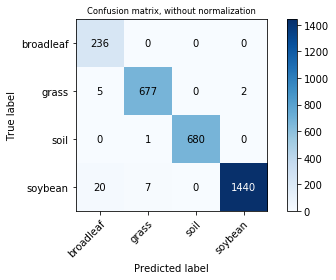

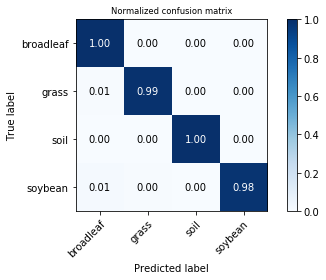

In [8]:
# ====== Random Seed Initialization ====== #
seed = 1
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp1_lr"

# ====== Model Capacity ====== #
args.act = 'relu'

# ====== Regularization ======= #
args.l2 = 0.00001

# ====== Optimizer & Training ====== #
args.optim = 'RMSprop'  # 'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.0015
args.epoch = 20

args.train_batch_size = 512
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'lr'
name_var2 = 'optim'
list_var1 = [0.0001]
list_var2 = ['RMSprop']

for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)

        setting, result = experiment(dataloaders, test_dataloaders, deepcopy(args))
        save_exp_result(setting, result)